In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torchvision import transforms as tfm

from sklearn import metrics as skmet
import matplotlib.pyplot as plt
import json
import transforms as my_transforms

import captum
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from collections import OrderedDict


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

%aimport dataset
%aimport transforms
%aimport models

ImageData = dataset.ImageData
CustomCrop = transforms.CustomCrop
VideoClassifier = models.VideoClassifier
VideoData = dataset.VideoData

In [3]:
# artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_justcolor_224x224'
artifact_folder = '/zfs/wficai/pda/model_run_artifacts/aihub_results_SAVE'

with open(artifact_folder + '/config.json', 'r') as f: 
    cfg = json.load(f)

# put all config variables in scope to avoid the need to laboriously index cfg
for k, v in cfg.items():
    v = f"'{v}'" if type(v)==str else v
    exec(f"{k}={v}")
del cfg

In [4]:
# optionally override settings
view_filter = ['pdaView', 'pdaRelatedView']
mode_filter = ['2d', 'color', 'color_compare']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')  # you may need 'cuda:0' 'cpu'

bs_test = 8

In [5]:
tfms = my_transforms.ImageTransforms(res)
tfms_test = tfms.get_transforms(transforms['test'])
tfms_plot = my_transforms.ImageTransforms(res).get_transforms('plot')

In [6]:
pdalist = ['/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0006.jpg',
 '/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0021.jpg',
 '/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0057.jpg',
 '/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0066.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0010.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0029.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0041.jpg',
 '/zfs/wficai/pda/model_data/20220901/nopda_study32_dicom83_frame0065.jpg']



In [7]:
df_test = pd.read_csv(f'{artifact_folder}/{out_paths["test"]}')
df_test_filtered = df_test[df_test.png_path.isin(pdalist)].sort_values('png_path')
#df_test_filtered.png_path.tolist()

In [8]:
d_test = ImageData(df_test_filtered, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers)
d_plot = ImageData(df_test_filtered, transforms = tfms_plot, mode_filter = mode_filter, view_filter = view_filter)
dl_plot = DataLoader(d_plot, batch_size=bs_test, num_workers=num_workers)

print("Number of frames after filtering:", len(d_test.data))
#print("Number of frames after filtering:", len(d_plot.data))

Number of frames after filtering: 8


In [9]:
# create model
m = timm.create_model(model, pretrained=pretrained, checkpoint_path = f"{artifact_folder}/model_checkpoint.ckpt", num_classes=num_classes, in_chans=3)
m.to(device)           
m.eval()

batch = next(iter(dl_test))
batchn = next(iter(dl_plot))

In [10]:
#video classifier
m_frames = timm.create_model(model, num_classes=num_classes, in_chans=3, drop_rate=dropout)

_ = m_frames.to(device)

# create video model
mVid = VideoClassifier(m_frames)

# load checkpoint
mVid.load_state_dict(torch.load(f"{artifact_folder}/model_checkpoint_video.ckpt"))

<All keys matched successfully>

In [11]:
#frame classifier from the video classifier
m_frames_trained = mVid.get_frame_classifier()

In [12]:
batch.keys()

dict_keys(['img', 'trg_type', 'trg_view', 'trg_mode', 'video', 'study', 'patient', 'imgr'])

In [13]:
batch['imgr'][7]

'/zfs/wficai/pda/model_data/20220901/pda_study36_dicom45_frame0066.jpg'

In [14]:
listA = ['Low', 'Med', 'High', 'Low', 'Low', 'High', 'Med-Low', 'High']

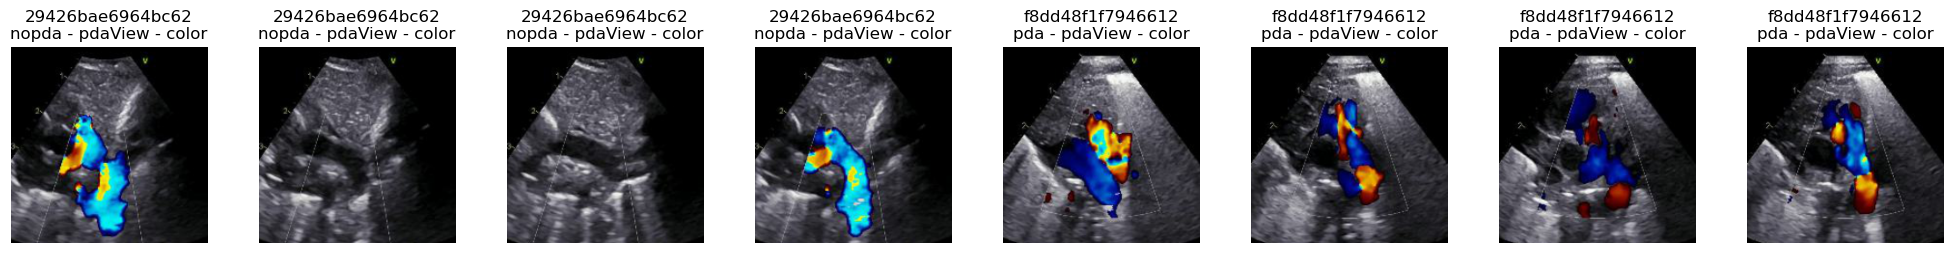

In [15]:
#display the normalized versions of images
ImageData.display_batch(batchn)

In [16]:
#using the model to make predictions on this batch
model = m_frames_trained #'m_frames_trained' is video frame classifier and 'm' is regular frame classifier
#model = m
output = model(batch['img'].to(device))
#print(output)
#print(output[0].item())

In [17]:
#Function takes input and returns the predicted value
def sigFunct(x):
    ix = x
    ix_ref = 1 #can be used as a baseline image

    #applying sigmoid function on output to find the predicted label
    s = torch.nn.Sigmoid()
    img = Image.open(batch['imgr'][ix])
    predicted = s(output[ix])
    if predicted >= 0.5:
        predicted_label = 'PDA'
    else:
        predicted_label = 'Non PDA'
    return(predicted_label)
    #display(img)

In [18]:
# function for converting figure to image
def fig2img(fig):
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img
    #use the following for adding image to subplot
    #img = fig2img(fig1[0])
    #ax[iNumber, ix].imshow(img)

In [25]:
#Giant figure

#unsqueeze adds a dimension to the tensor
fig, ax = plt.subplots(nrows=5, ncols=8, sharex=True, sharey=True, dpi=600,  figsize = (16,10))
fig.tight_layout()
for ix in range (0, 8):
    iNumber = 0
    
    input = batch['img'][ix].unsqueeze(0).to(device) #input is the unsqueezed version of the image
    #baseline = batch['img'][ix_ref].unsqueeze(0).to(device) #can be used for baseline
    transformed_img = batchn['img'][ix] #this is the normalized image, creates more contrast

    #uses integrated gradients function to create the integrated gradients
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, n_steps=200) #creates the attributions with n_steps

    #sets the cmap for the attribution display figure
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    #noise tunnel implementation
    noise_tunnel = NoiseTunnel(integrated_gradients)

    #the noise tunnel adds gaussian noise to the input nt_sample times and applies the attribution to each sample
    attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', nt_samples_batch_size = 1)


    #displays original image
    fig1 = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "original_image",
                                          "all",
                                          cmap=default_cmap,
                                          plt_fig_axis=(fig,ax[iNumber, ix]), 
                                          use_pyplot=False)


    iNumber += 1
    #heat map for attribution plot with noise tunnel 
    fig1 = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "heat_map",
                                          "positive",
                                          cmap=default_cmap,
                                          plt_fig_axis=(fig,ax[iNumber, ix]), 
                                          use_pyplot=False)

    iNumber += 1
    #alpha scaling for heat map
    fig1 = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "alpha_scaling",
                                          "positive",
                                          cmap=default_cmap,
                                          plt_fig_axis=(fig,ax[iNumber, ix]),
                                          use_pyplot=False)
    
    #occlusion approach
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input,
                                           strides = (3, 25, 25),
                                           sliding_window_shapes=(3,30, 30),
                                           baselines=0)
    
    #heat map for the occlusions
    iNumber += 1
    fig1 = viz.visualize_image_attr(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "heat_map",
                                          "positive",
                                          outlier_perc=2,
                                          plt_fig_axis=(fig,ax[iNumber, ix]),
                                          use_pyplot=False)
    
    #alpha scaling for the occlusion
    iNumber += 1    
    fig1 = viz.visualize_image_attr(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      "alpha_scaling",
                                      "positive",
                                      outlier_perc=2,
                                      plt_fig_axis=(fig,ax[iNumber, ix]),
                                        use_pyplot=False)
    name = sigFunct(ix)
    ax[0, ix].set_title((name + ' ' + listA[ix]),  fontsize=6)
    
    
ax[0,0].set_ylabel("Original Image",  fontsize=4)
ax[1,0].set_ylabel("Heat Map",  fontsize=4)
ax[2,0].set_ylabel("Alpha Scaling",  fontsize=4)
ax[3,0].set_ylabel("Occlusion Heat Map",  fontsize=4)
ax[4,0].set_ylabel("Occlusion Alpha Scaling",  fontsize=4)




Text(922.8333333333334, 0.5, 'Occlusion Alpha Scaling')

In [20]:
fig.savefig('interpretabilityChart.png')

In [26]:
#unsqueeze adds a dimension to the tensor
fig, ax = plt.subplots(nrows=3, ncols=8, sharex=True, sharey=True, dpi=600,  figsize = (24,9))
fig.tight_layout()
for ix in range (0, 8):
    iNumber = 0
    
    input = batch['img'][ix].unsqueeze(0).to(device) #input is the unsqueezed version of the image
    #baseline = batch['img'][ix_ref].unsqueeze(0).to(device) #can be used for baseline
    transformed_img = batchn['img'][ix] #this is the normalized image, creates more contrast

    #uses integrated gradients function to create the integrated gradients
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, n_steps=200) #creates the attributions with n_steps

    #sets the cmap for the attribution display figure
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    #noise tunnel implementation
    noise_tunnel = NoiseTunnel(integrated_gradients)

    #the noise tunnel adds gaussian noise to the input nt_sample times and applies the attribution to each sample
    attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', nt_samples_batch_size = 1)


    #displays original image
    fig1 = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "original_image",
                                          "all",
                                          cmap=default_cmap,
                                          plt_fig_axis=(fig,ax[iNumber, ix]), 
                                          use_pyplot=False)
    iNumber += 1
    #heat map for attribution plot with noise tunnel 
    fig1 = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "heat_map",
                                          "positive",
                                          cmap=default_cmap,
                                          plt_fig_axis=(fig,ax[iNumber, ix]), 
                                          use_pyplot=False)
    
    
    #Same stuff but with the new model
    model = m
    output = model(batch['img'].to(device))
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, n_steps=200) #creates the attributions with n_steps

    #sets the cmap for the attribution display figure
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    #noise tunnel implementation
    noise_tunnel = NoiseTunnel(integrated_gradients)

    #the noise tunnel adds gaussian noise to the input nt_sample times and applies the attribution to each sample
    attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', nt_samples_batch_size = 1)
    
    iNumber += 1
    #heat map for attribution plot with noise tunnel 
    fig1 = viz.visualize_image_attr(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          "heat_map",
                                          "positive",
                                          cmap=default_cmap,
                                          plt_fig_axis=(fig,ax[iNumber, ix]), 
                                          use_pyplot=False)

    name = sigFunct(ix)
    ax[0, ix].set_title((name + ' ' + listA[ix]),  fontsize=6)
    
    
ax[0,0].set_ylabel("Original Image",  fontsize=4)
ax[1,0].set_ylabel("Video Classifier Heat Map",  fontsize=4)
ax[3,0].set_ylabel("Frame Classifier Heat Map",  fontsize=4)



Error in callback <function flush_figures at 0x148f5396a310> (for post_execute):



KeyboardInterrupt


KeyboardInterrupt



In [ ]:
#interpretability with gradientShap, which is different from integrated gradients, SHAP = SHapley Additive exPlanations
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist)
figShap, _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "alpha_scaling"],
                                      ["all", "positive", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
#occlusion model implementation
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 25, 25),
                                       sliding_window_shapes=(3,30, 30),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "alpha_scaling"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
#print(model)

In [ ]:
#model.layer4[2]

In [ ]:
#guidGradCam = captum.attr.GuidedGradCam(model, layer = model.layer4[2].conv3)

#attributions_GradCam = guidGradCam.attribute(input)